In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
import spectral

## Multiplication Matrices

In [2]:
N = 64
x_basis = spectral.Chebyshev(N)
x = x_basis.grid()
domain = spectral.Domain([x_basis])

In [3]:
C = x_basis.convert_TU()
D = x_basis.derivative_TU()
Z = sparse.csr_matrix((N, N))

Let's make a matrix which multiplies by $T_1(x) = x$.

In [4]:
mult_T1 = sparse.lil_matrix((N, N))
for k in range(N):
    if k+1 < N:
        mult_T1[k+1, k] += 1/2
    if (k-1) < N:
        mult_T1[abs(k-1), k] += 1/2

<IPython.core.display.Javascript object>


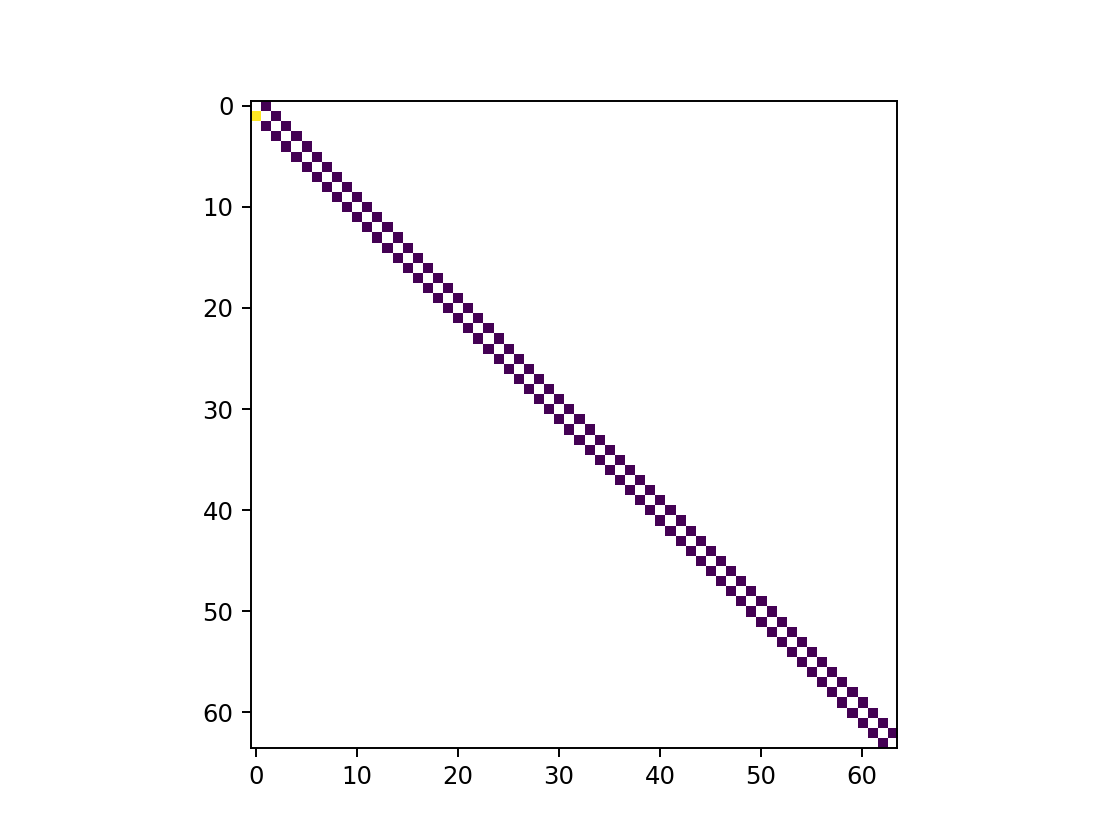

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_47970/2607429074.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(mult_T1.A)))


In [5]:
plt.figure()
plt.imshow(np.log(np.abs(mult_T1.A)))

In [6]:
u = spectral.Field(domain)
u.require_grid_space()
u.data = np.sin(x*np.pi)

<IPython.core.display.Javascript object>


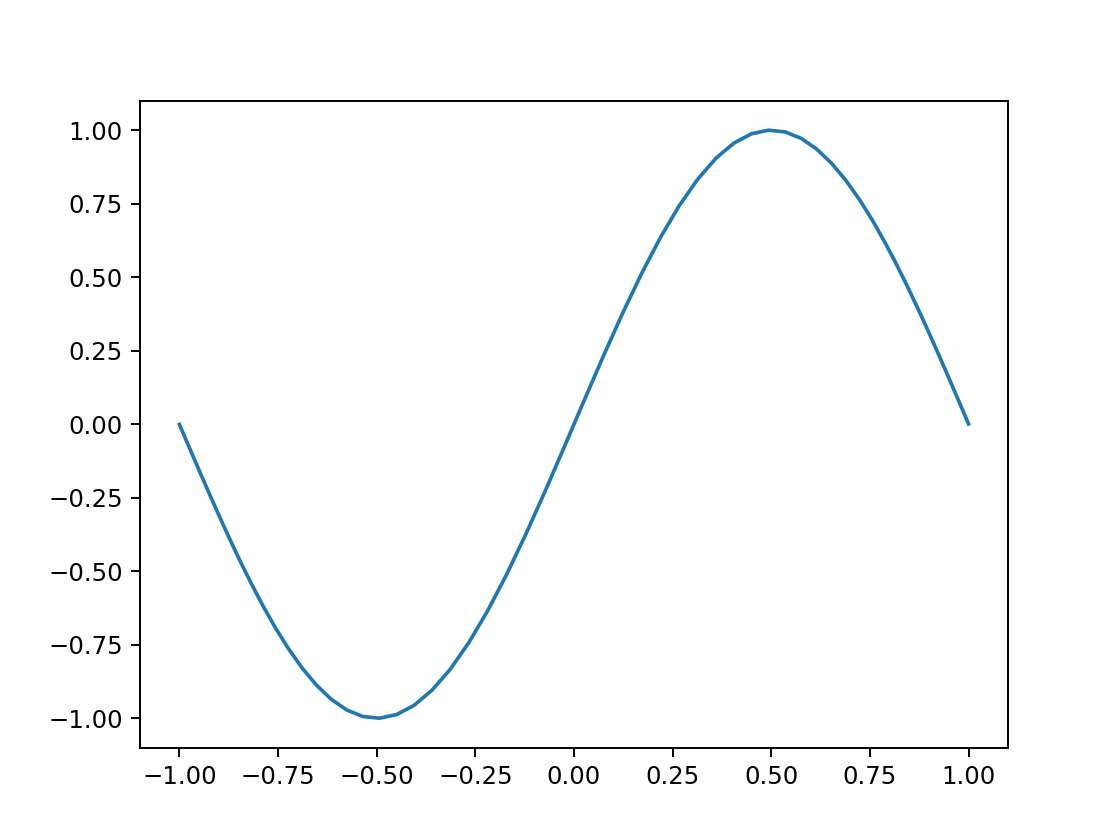

In [9]:
plt.figure()
plt.plot(x, u.data)

In [10]:
v = spectral.Field(domain)
u.require_coeff_space()
v.require_coeff_space()

In [11]:
v.data = mult_T1 @ u.data

<IPython.core.display.Javascript object>


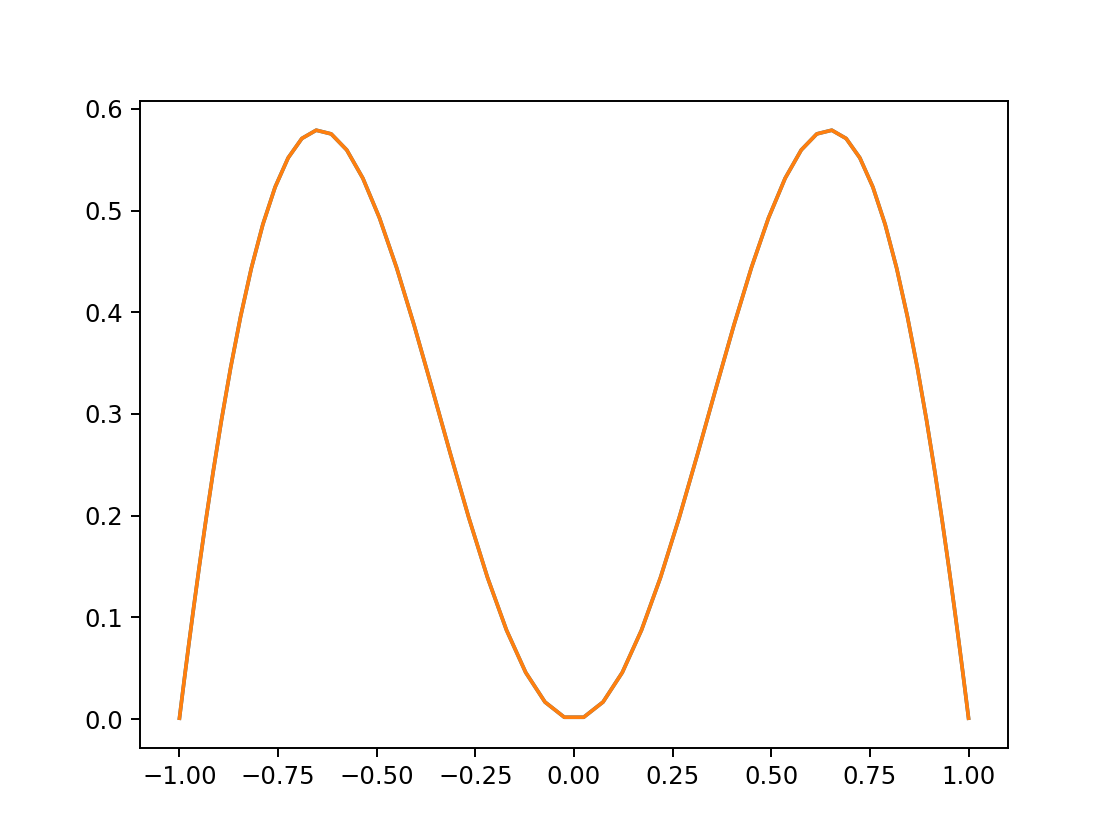

In [14]:
plt.figure()
v.require_grid_space()
plt.plot(x, v.data)
plt.plot(x, x*np.sin(np.pi*x))

We want to multiply by $c^2 = x^2+1$. For that, we need the Chebyshev coefficients of $c^2$.

In [15]:
c2 = spectral.Field(domain)
c2.require_grid_space()
c2.data = x**2+1

In [16]:
c2.require_coeff_space()
c2.data

array([ 1.50000000e+00,  2.11859375e-17,  5.00000000e-01, -6.17346985e-17,
       -5.15517762e-19, -3.07077695e-17, -8.96058608e-18,  3.47547370e-17,
        2.31092931e-18, -1.32915693e-17,  3.51291255e-17, -5.21202920e-17,
        4.82686536e-18, -2.12033713e-18, -4.12078631e-17, -1.59497679e-18,
       -7.96619921e-18, -2.94708260e-17,  4.65578288e-17, -1.26024778e-17,
        3.21255113e-18, -6.37845216e-18, -1.81721056e-17,  3.00530597e-19,
       -1.12911592e-18, -4.59898973e-18, -2.57126195e-17, -1.32398459e-17,
       -9.56192025e-18, -1.50709191e-18, -1.76764955e-17, -3.45258868e-18,
        0.00000000e+00, -1.66227319e-17,  4.01680402e-17, -1.78858937e-17,
        1.16512335e-17, -4.04537109e-18, -5.71436573e-17, -2.84601923e-17,
        1.68984140e-18, -2.45553447e-17, -3.50979274e-17,  1.15884993e-17,
       -6.01026043e-18, -2.64823932e-17,  3.54529655e-17, -1.55157655e-17,
        1.92321062e-17,  3.10330932e-17,  2.76313451e-17,  1.59954225e-17,
       -1.59120426e-17, -

In [17]:
mult_T2 = sparse.lil_matrix((N, N))
for k in range(N):
    if k+2 < N:
        mult_T2[k+2, k] += 1/2
    if (k-2) < N:
        mult_T2[abs(k-2), k] += 1/2

<IPython.core.display.Javascript object>


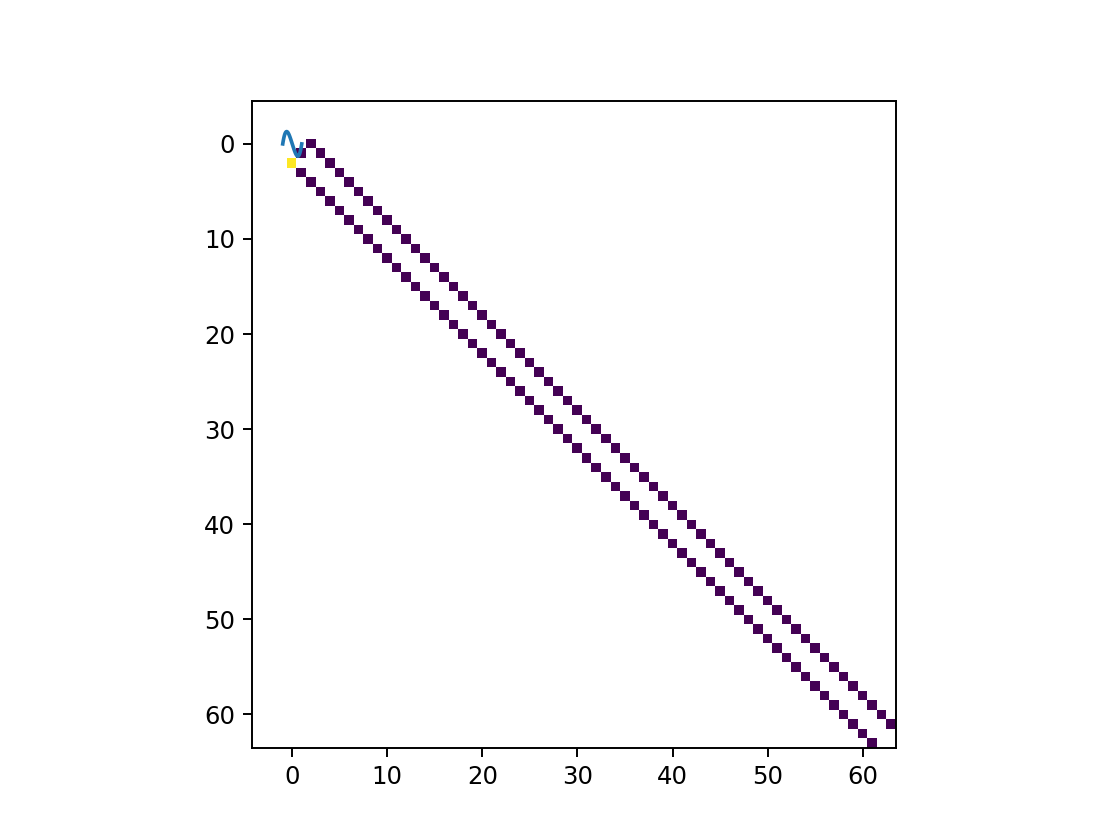

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_47970/2822488767.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(mult_T2.A)))


In [18]:
plt.figure()
plt.imshow(np.log(np.abs(mult_T2.A)))

In [20]:
mult_c2 = 0.5*mult_T2 + 1.5*sparse.eye(N)

In [21]:
v.require_coeff_space()
u.require_coeff_space()
v.data = mult_c2 @ u.data

<IPython.core.display.Javascript object>


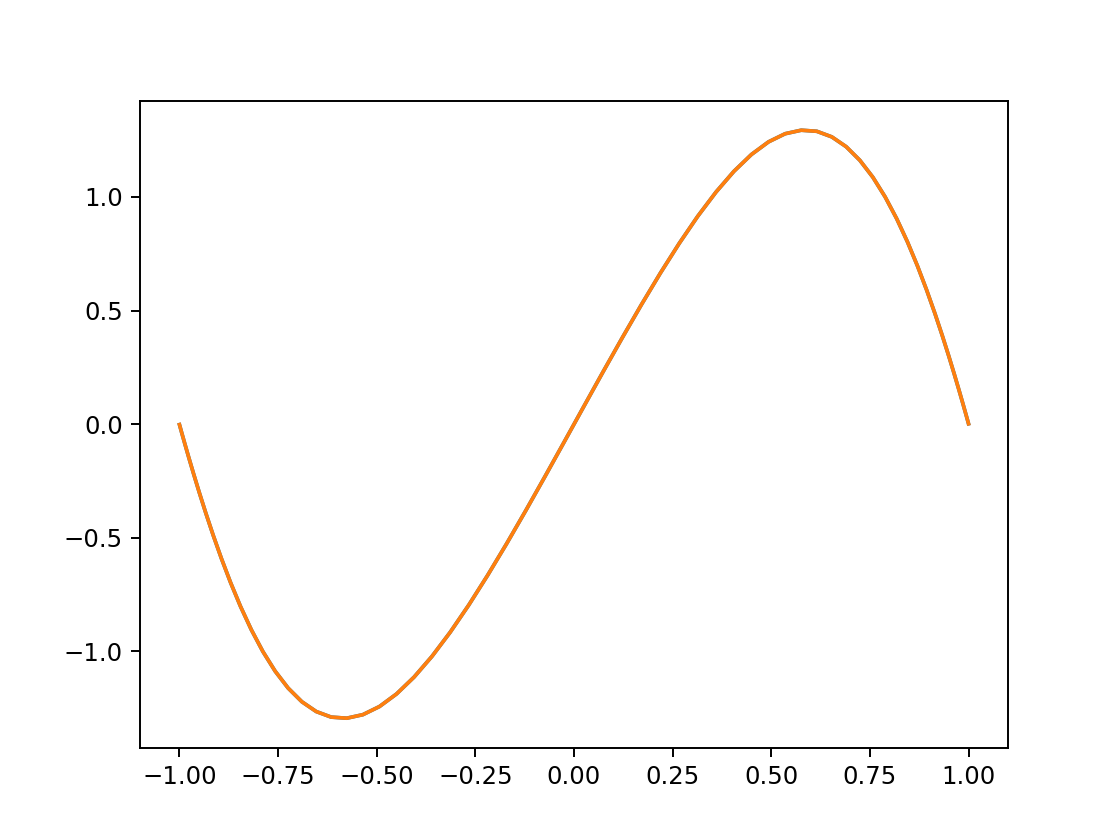

In [24]:
v.require_grid_space()
plt.figure()
plt.plot(x, v.data)
plt.plot(x, np.sin(np.pi*x)*(x**2+1))

We want to solve the eigenvalue problem:
$$ \partial_t^2 u = \partial_x(c^2 \partial_x u), \\
u(\pm 1) = 0$$
where $c^2 = 1+x^2$.

In [25]:
M = sparse.csr_matrix((2*N+2, 2*N+2))
M[N:2*N, :N] = C

L = sparse.bmat([[D, -C],
                 [Z,  D @ mult_c2]])

i = np.arange(N)
BC_rows = np.zeros((2, 2*N))
BC_rows[0, :N] = (-1)**i
BC_rows[1, :N] = (+1)**i

cols = np.zeros((2*N, 2))
cols[  N-1, 0] = 1
cols[2*N-1, 1] = 1

corner = np.zeros((2, 2))

L = sparse.bmat([[L, cols],
                 [BC_rows, corner]])

/opt/miniconda3/envs/dedalus3/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Let's do a dense solve to get all the eigenvalues of this problem.

In [26]:
# :(
L = L.A
M = M.A

In [27]:
values, vectors = scipy.linalg.eig(-L, M)

finite = np.isfinite(values)
values = values[finite]
vectors = vectors[:, finite]

order = np.argsort(values.real)
values = values[order]
vectors = vectors[:, order]

om = np.sqrt(values)

In [28]:
om

array([   1.91163823+0.j,    3.62762675+0.j,    5.38877909+0.j,
          7.16045795+0.j,    8.93635136+0.j,   10.71435173+0.j,
         12.493556  +0.j,   14.27351271+0.j,   16.05397104+0.j,
         17.83478049+0.j,   19.61584532+0.j,   21.39710167+0.j,
         23.17850534+0.j,   24.96002478+0.j,   26.74163682+0.j,
         28.5233241 +0.j,   30.30507335+0.j,   32.08687423+0.j,
         33.86871861+0.j,   35.65059992+0.j,   37.43251272+0.j,
         39.21445331+0.j,   40.99642042+0.j,   42.77840234+0.j,
         44.56037405+0.j,   46.34242724+0.j,   48.1247226 +0.j,
         49.9065467 +0.j,   51.68718427+0.j,   53.47209074+0.j,
         55.26431573+0.j,   57.05693653+0.j,   58.85104626+0.j,
         60.77845992+0.j,   62.77723529+0.j,   64.93784947+0.j,
         67.09240889+0.j,   69.88034388+0.j,   72.64859051+0.j,
         75.84036227+0.j,   78.82084049+0.j,   83.07011921+0.j,
         87.11295996+0.j,   91.87850656+0.j,   96.22548117+0.j,
        102.79313089+0.j,  109.08655974+

<IPython.core.display.Javascript object>


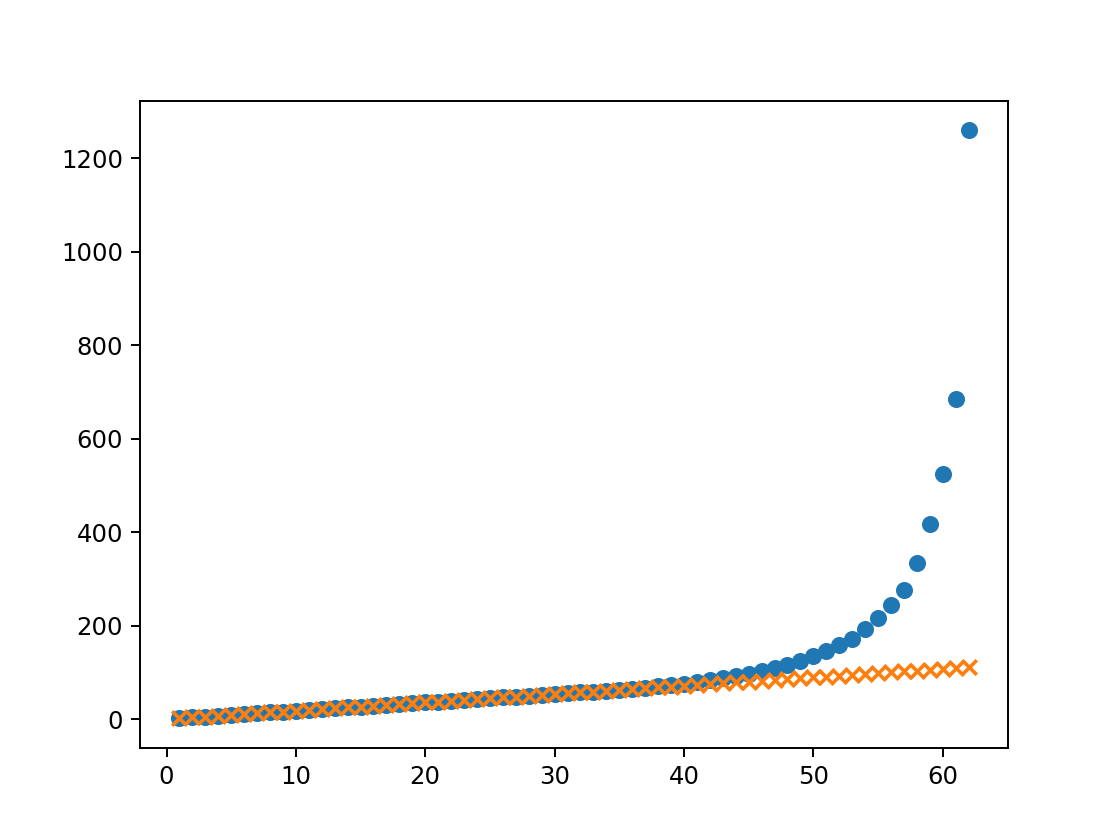

In [30]:
i = np.arange(len(om))+1
plt.figure()
plt.scatter(i, om)
plt.scatter(i, np.pi*i/1.76, marker='x')

<IPython.core.display.Javascript object>


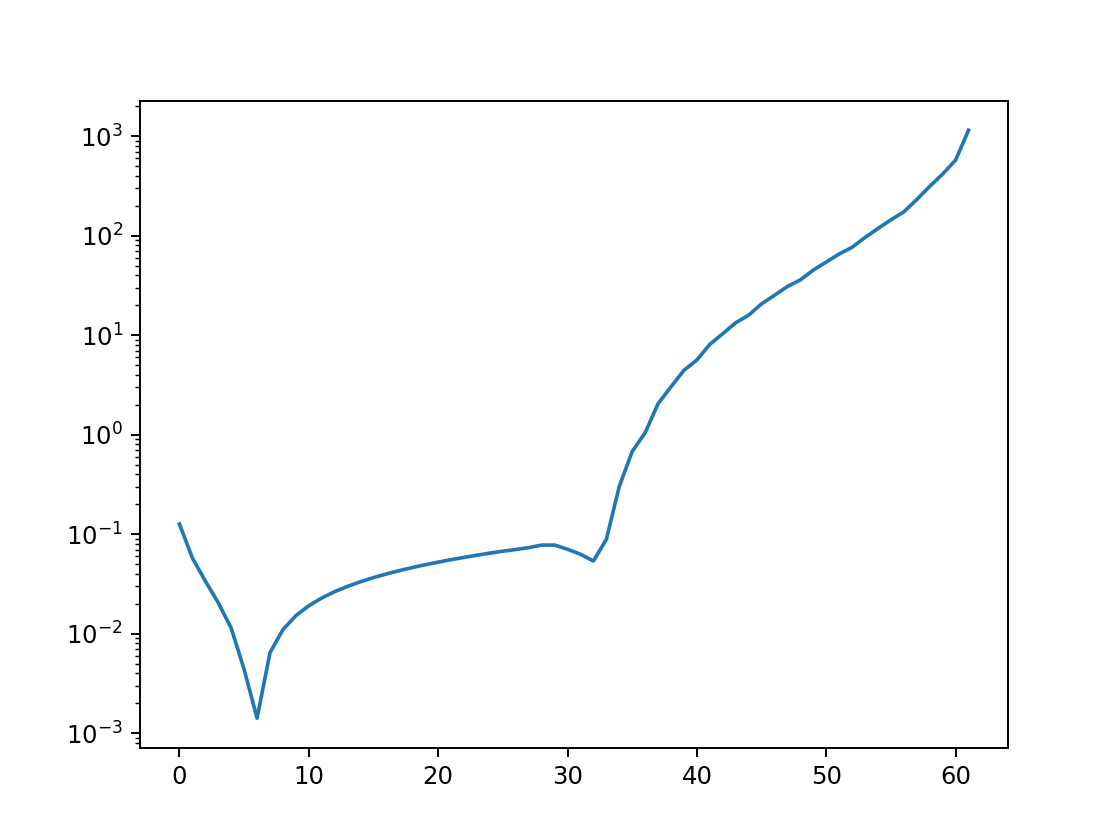

In [31]:
error = np.abs(om - np.pi*i/1.76)
plt.figure()
plt.plot(error)
plt.yscale('log')

## Using Dedalus

In [32]:
import dedalus.public as d3

2022-03-11 14:45:41,333 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2022-03-11 14:45:41,335 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2022-03-11 14:45:41,504 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


In [45]:
# Parameters
Lx, Lz = 1, 2
Nx, Nz = 128, 256
#Nx, Nz = 8, 16
Reynolds = 5e4
Schmidt = 1
dealias = 3/2
stop_sim_time = 5
timestepper = d3.RK222
max_timestep = 1e-2
dtype = np.float64

In [46]:
# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(-Lz/2, Lz/2), dealias=dealias)

In [47]:
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
s = dist.Field(name='s', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')

In [48]:
# Substitutions
nu = 1 / Reynolds
D = nu / Schmidt
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
xm, ym = np.meshgrid(x.ravel(), z.ravel())

In [49]:
# Problem
problem = d3.IVP([u, s, p, tau_p], namespace=locals())
problem.add_equation("dt(u) + grad(p) - nu*lap(u) = -dot(u, grad(u))")
problem.add_equation("dt(s) - D*lap(s) = -dot(u, grad(s))")
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("integ(p) = 0")

In [50]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2022-03-11 14:51:34,023 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s
2022-03-11 14:51:34,178 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.6e+01/s
2022-03-11 14:51:34,361 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s
2022-03-11 14:51:34,553 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s
2022-03-11 14:51:34,759 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s
2022-03-11 14:51:34,932 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s
2022-03-11 14:51:35,112 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s
2022-03-11 14:51:35,294 subsystems 0/1 INFO :: Building subproblem matri

<IPython.core.display.Javascript object>


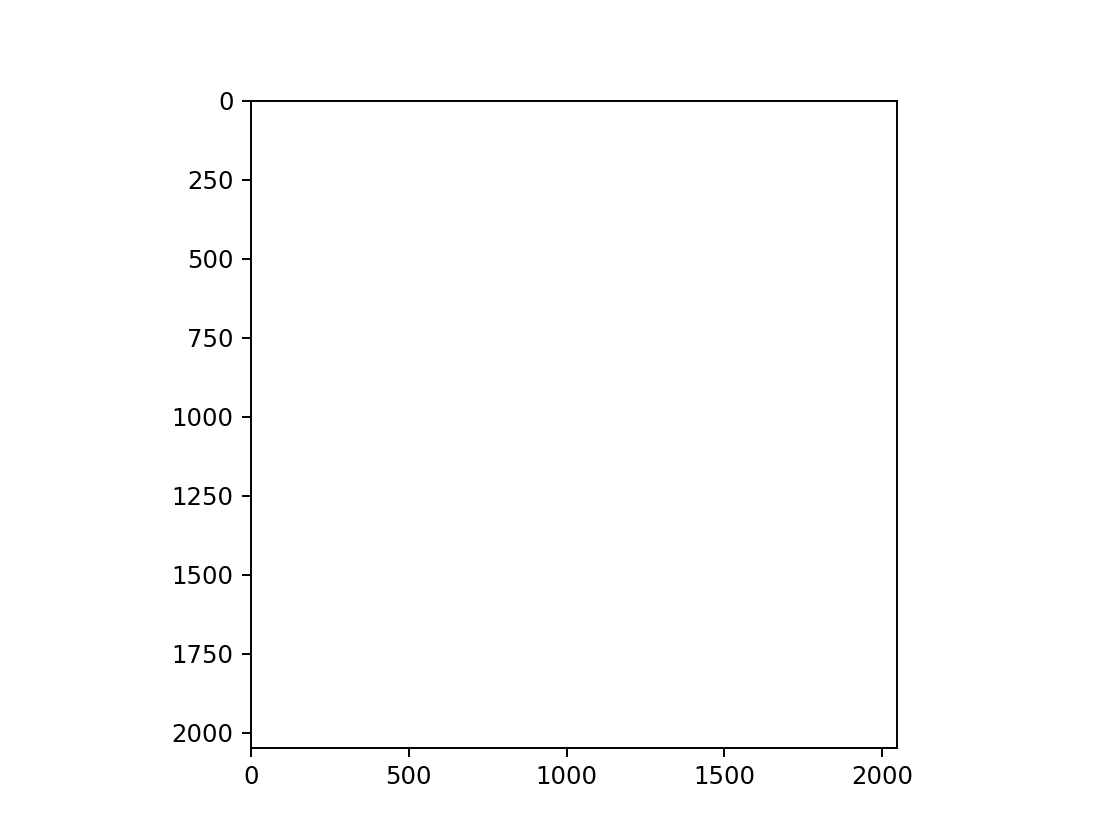

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_47970/3322396982.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(L.A)))


In [51]:
plt.figure()
sp = solver.subproblems[3]
M = sp.pre_left.T @ sp.M_min
L = sp.pre_left.T @ sp.L_min
plt.imshow(np.log(np.abs(L.A)))

In [52]:
# Initial conditions
# Background shear
u['g'][0] = 1/2 + 1/2 * (np.tanh((z-0.5)/0.1) - np.tanh((z+0.5)/0.1))
# Match tracer to shear
s['g'] = u['g'][0]
# Add small vertical velocity perturbations localized to the shear layers
u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(z-0.5)**2/0.01)
u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(z+0.5)**2/0.01)

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.2, threshold=0.1,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

<IPython.core.display.Javascript object>


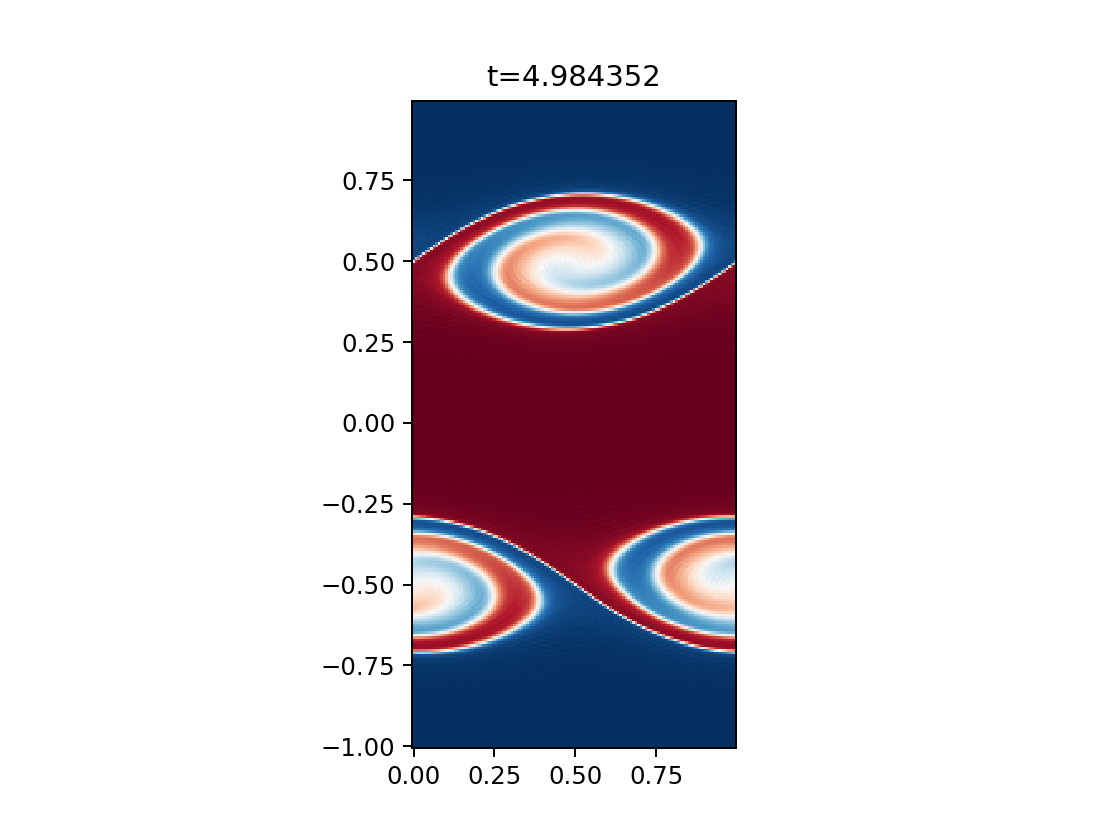

2022-03-11 14:53:25,468 solvers 0/1 INFO :: Simulation stop time reached.


In [53]:
fig = plt.figure()
ax = fig.subplots(1)
s.change_scales((1, 1))
pcm = ax.pcolormesh(xm, ym, s['g'].T, cmap='RdBu', vmax=1/2, vmin=-1/2)
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %solver.sim_time)

while solver.proceed:
    timestep = CFL.compute_timestep()
    solver.step(timestep)
    if (solver.iteration-1) % 10 == 0:
        title.set_text('t=%f' %solver.sim_time)
        s.change_scales((1, 1))
        pcm.set_array(s['g'].T.ravel())
        fig.canvas.draw()